In [1]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa


c:\miniconda\envs\newenv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
def resize_imgs(X):
    X_out = []
    for img in X:
        img = cv2.resize(img,(32,32))
        X_out.append(img)
    X_out = np.array(X_out)
    return X_out

In [3]:
def build_model(n_labels):

    # initialize model
    model = Sequential()

    # feature detector
    model.add(Conv2D(32, (3, 3), activation='relu',  padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu',  padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # classifier
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(n_labels, activation='softmax'))

    # compiler
    model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

    return model

use adam optimizer for more accuracy

In [4]:
def train_model(model,X_train,y_train,X_test,y_test,n_epochs,batch_size):

    h = model.fit(X_train,y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test,y_test))#, verbose=0)

    return h

In [5]:
def calc_accuracy(model,X,y):

    _, accuracy = model.evaluate(X,y)
    print('Accuracy value: %f ' % (accuracy*100) )

In [6]:
X_train, y_train = [],[]
rows = open("/path/to/folder/Train.csv").read().strip().split("\n")[1:]
random.shuffle(rows)
for row in rows:
    label, img_path = row.strip().split(",")[-2:]
    full_img_path = "/path/to/folder/" + img_path  # Ensure the path is correct
    img = cv2.imread(full_img_path, cv2.IMREAD_UNCHANGED)

    if img is not None:
        # Resize the image
        img_resized = cv2.resize(img, (32,32))
        
        # If the image is grayscale, convert it to RGB
        if img_resized.ndim == 2:
            img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
        
        X_train.append(img_resized)
        y_train.append(int(label))

X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

(20878, 32, 32, 3) (20878,)


In [7]:
X_test, y_test = [],[]
rows = open("/path/to/folder/Test.csv").read().strip().split("\n")[1:]
random.shuffle(rows)
for row in rows:
    label, img_path = row.strip().split(",")[-2:]
    full_img_path = "/path/to/folder/" + img_path  # Ensure the path is correct
    img = cv2.imread(full_img_path, cv2.IMREAD_UNCHANGED)

    if img is not None:
        # Resize the image
        img_resized = cv2.resize(img, (32,32))
        
        # If the image is grayscale, convert it to RGB
        if img_resized.ndim == 2:
            img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
        
        X_test.append(img_resized)
        y_test.append(int(label))

X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test.shape, y_test.shape)

(6779, 32, 32, 3) (6779,)


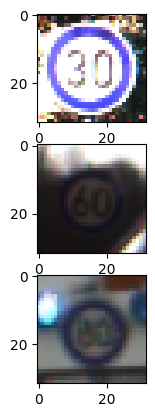

Labels:  1 3 5


In [8]:
idx = [15,2500,9999]
fig,axes = plt.subplots(3)
axes[0].imshow(X_train[idx[0]])
axes[1].imshow(X_train[idx[1]])
axes[2].imshow(X_train[idx[2]])
plt.show()

print('Labels: ',y_train[idx[0]],y_train[idx[1]],y_train[idx[2]])

In [9]:
labels_list = ['Speed limit (20km/h)','Speed limit (30km/h)','Speed limit (50km/h)','Speed limit (60km/h)',
                'Speed limit (70km/h)','Speed limit (80km/h)','Speed limit (100km/h)','Speed limit (120km/h)',
                'Yield','Stop','No entry','Road work','Pedestrians','Turn right ahead','Turn left ahead',
                'Ahead only']

In [10]:
n_labels = len(np.unique(y_train))
y_train = to_categorical(y_train,n_labels)
y_test = to_categorical(y_test,n_labels)

X_train = resize_imgs(X_train)
X_test = resize_imgs(X_test)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train / 255.0
X_test = X_test / 255.0

In [11]:
def predict_imgs(path, model_name, X_test, labels_list):
    # Load model
    model = load_model(path + model_name)

    # Ensure the input image is in the correct format
    img = cv2.resize(X_test[1000], (32, 32))
    img_to_pred = np.expand_dims(img, axis=0)  # Equivalent to img.reshape(1, 32, 32, 3)

    # Plot image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct plotting
    plt.show()

    # Predict
    predictions = model.predict(img_to_pred)
    y_pred = np.argmax(predictions, axis=1)  # Get the index of the max probability
    label_pred = labels_list[y_pred[0]]

    return label_pred

In [12]:
def plot_history(h):

    fig = plt.subplots(1)
    plt.plot(h.history['accuracy'], label='train accuracy')
    plt.plot(h.history['val_accuracy'], label='test accuracy')
    plt.title('Classifier CNN evaluation')
    plt.legend()
    plt.show()

Epoch 1/10
653/653 [==============================] - 18s 26ms/step - loss: 2.1741 - accuracy: 0.2811 - val_loss: 1.5373 - val_accuracy: 0.4495
Epoch 2/10
653/653 [==============================] - 17s 26ms/step - loss: 1.3522 - accuracy: 0.5142 - val_loss: 1.2182 - val_accuracy: 0.5437
Epoch 3/10
653/653 [==============================] - 17s 26ms/step - loss: 1.0429 - accuracy: 0.6237 - val_loss: 1.0246 - val_accuracy: 0.6370
Epoch 4/10
653/653 [==============================] - 20s 31ms/step - loss: 0.7735 - accuracy: 0.7304 - val_loss: 0.7952 - val_accuracy: 0.7334
Epoch 5/10
653/653 [==============================] - 17s 26ms/step - loss: 0.5827 - accuracy: 0.8045 - val_loss: 0.6778 - val_accuracy: 0.7851
Epoch 6/10
653/653 [==============================] - 16s 25ms/step - loss: 0.4356 - accuracy: 0.8573 - val_loss: 0.5836 - val_accuracy: 0.8355
Epoch 7/10
653/653 [==============================] - 17s 25ms/step - loss: 0.3368 - accuracy: 0.8933 - val_loss: 0.5260 - val_accuracy:

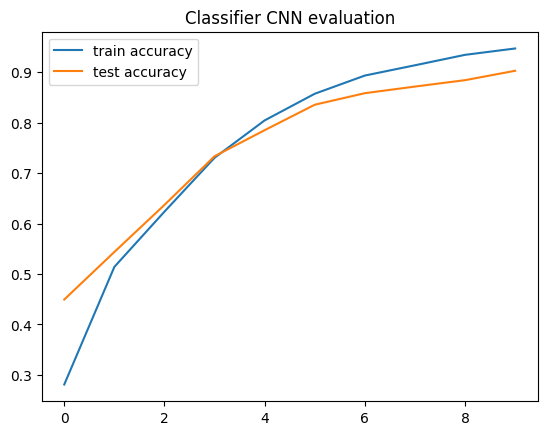

In [13]:
model = build_model(len(labels_list))

n_epochs = 10
batch_size = 32
h = train_model(model,X_train,y_train,X_test,y_test,n_epochs,batch_size)

calc_accuracy(model,X_test,y_test)

plot_history(h)

In [ ]:
model_name = "cnn_traffic_sign.h5"
path = "/path/to/folder/"
print(predict_imgs(path,model_name,X_test, labels_list))